In [2]:
!pip install pandas numpy matplotlib scikit-learn scipy statsmodels


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python3 -m pip install --upgrade pip


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.cluster import KMeans
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm
from scipy import stats

np.random.seed(42)

# -----------------------------
# 1. Regression (Marketing Mix)
# -----------------------------
n_months = 24
df_reg = pd.DataFrame({
    'PaidSearch': np.random.randint(1000, 5000, n_months),
    'Facebook': np.random.randint(500, 3000, n_months),
    'Email': np.random.randint(200, 800, n_months)
})

# Generate conversions with some true weights + noise
df_reg['Conversions'] = (
    df_reg['PaidSearch'] * 0.05 +
    df_reg['Facebook'] * 0.03 +
    df_reg['Email'] * 0.08 +
    np.random.normal(0, 30, n_months)
)

X = sm.add_constant(df_reg[['PaidSearch', 'Facebook', 'Email']])
y = df_reg['Conversions']
model_reg = sm.OLS(y, X).fit()
print("\n--- Regression (Channel ROI) ---")
print(model_reg.summary())


--- Regression (Channel ROI) ---
                            OLS Regression Results                            
Dep. Variable:            Conversions   R-squared:                       0.879
Model:                            OLS   Adj. R-squared:                  0.861
Method:                 Least Squares   F-statistic:                     48.33
Date:                Tue, 02 Sep 2025   Prob (F-statistic):           2.39e-09
Time:                        09:29:03   Log-Likelihood:                -109.31
No. Observations:                  24   AIC:                             226.6
Df Residuals:                      20   BIC:                             231.3
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.8

# High-level model stats

Dep. Variable: Conversions → The outcome we’re predicting.

R-squared = 0.879 → About 88% of the variation in conversions is explained by ad spend (PaidSearch, Facebook, Email). This is quite strong.

Adj. R-squared = 0.861 → Adjusted for number of predictors. Still high → model fits well.

F-statistic = 48.33, p < 0.001 → Overall, the regression model is statistically significant (the predictors matter).

✅ Interpretation: Your marketing spend variables explain conversions very well.

# Coefficients (Channel ROI)

Each coefficient represents the expected change in conversions for a 1-unit increase in spend in that channel, holding others constant.

const = 5.85
→ If all spend = 0, we’d still expect ~6 conversions (baseline).
→ But not very important for decision-making.

PaidSearch = 0.0532, p < 0.001
→ For every extra $1 spent in Paid Search, we gain ~0.053 conversions.
→ Scale up: +$1000 spend = +53 conversions.
→ Strong, highly significant.

Facebook = 0.0250, p = 0.003
→ For every extra $1 in FB ads, we gain ~0.025 conversions.
→ +$1000 spend = +25 conversions.
→ Still significant, but less efficient than Paid Search.

Email = 0.0590, p ≈ 0.050
→ +$1 in email campaigns ≈ +0.059 conversions.
→ +$1000 spend = +59 conversions.
→ Borderline significance (p = 0.05). Suggests email is strong but with variability (maybe because the sample is small).

✅ Interpretation: Email looks most efficient, but it’s borderline in statistical significance. PaidSearch is very strong and reliable.

# Statistical tests

t-values (11.7 for PaidSearch, 3.35 for Facebook, 2.08 for Email): Higher t = stronger evidence that the variable matters.

p-values:

<0.05 → statistically significant (real effect).

PaidSearch and Facebook are clearly significant.

Email just barely passes the 0.05 threshold.

Other diagnostics

Durbin-Watson = 1.89 → Checks for autocorrelation in residuals. Values near 2 are fine → no major issues.

Condition Number = 1.9e+04 → A bit large. Suggests multicollinearity (channels may be correlated with each other, e.g., PaidSearch and Facebook spend move together).
→ In real marketing mix models, this is common — channels’ spend budgets often rise/fall together.

# 📊 Marketing Analyst Takeaway

PaidSearch is consistently delivering strong incremental conversions.

Facebook works, but is less efficient per dollar.

Email seems most efficient, but with less certainty (maybe sample size issue or campaign variability).

R² shows the model explains the majority of variation — you can use this to guide budget reallocation.

Watch out for multicollinearity: If channels are correlated, it can inflate uncertainty around coefficients.

In [3]:
# -----------------------------
# 2. Logistic Regression (Purchases)
# -----------------------------
n_users = 200
df_log = pd.DataFrame({
    'TimeOnSite': np.random.uniform(0.5, 10, n_users),
    'PagesViewed': np.random.randint(1, 20, n_users),
    'ClickedEmail': np.random.binomial(1, 0.4, n_users)
})

# True logistic model for generating purchases
logit_score = (0.3*df_log['TimeOnSite'] +
               0.15*df_log['PagesViewed'] +
               1.5*df_log['ClickedEmail'] - 4)
prob = 1 / (1 + np.exp(-logit_score))
df_log['Purchased'] = np.random.binomial(1, prob)

X_train, X_test, y_train, y_test = train_test_split(
    df_log[['TimeOnSite', 'PagesViewed', 'ClickedEmail']],
    df_log['Purchased'], test_size=0.3, random_state=42
)

model_log = LogisticRegression()
model_log.fit(X_train, y_train)
y_pred = model_log.predict(X_test)

print("\n--- Logistic Regression (Purchase Prediction) ---")
print(classification_report(y_test, y_pred))
print("Coefficients:", dict(zip(['TimeOnSite','PagesViewed','ClickedEmail'], model_log.coef_[0])))



--- Logistic Regression (Purchase Prediction) ---
              precision    recall  f1-score   support

           0       0.68      0.81      0.74        31
           1       0.74      0.59      0.65        29

    accuracy                           0.70        60
   macro avg       0.71      0.70      0.69        60
weighted avg       0.71      0.70      0.70        60

Coefficients: {'TimeOnSite': np.float64(0.41517303271538536), 'PagesViewed': np.float64(0.19145053599653183), 'ClickedEmail': np.float64(0.8743506320642035)}


# 1. Classification Report

This comes from classification_report(y_test, y_pred) and shows how well the model predicts purchasers (1) vs. non-purchasers (0).

Class 0 = Did NOT purchase

Precision = 0.68 → When the model predicts “no purchase,” it’s correct 68% of the time.

Recall = 0.81 → Of all the true non-purchasers, the model correctly catches 81%.

F1 = 0.74 → Balance between precision & recall.

👉 Good recall here means the model is pretty reliable at detecting who won’t buy.

Class 1 = Purchased

Precision = 0.74 → When the model predicts “purchase,” it’s correct 74% of the time.

Recall = 0.59 → It only catches 59% of the actual purchasers.

F1 = 0.65 → Weaker than Class 0.

👉 This means the model misses some true buyers — maybe being conservative in predicting purchases.

Overall

Accuracy = 0.70 → 70% of users classified correctly.

Macro avg (0.69) → Average across both classes, treating them equally.

Weighted avg (0.70) → Weighted by support (more users in class 0 than 1).

✅ Marketing takeaway: The model is decent (70% accuracy) but better at spotting non-buyers than buyers. For growth marketing, you may want to tune for higher recall on buyers (class 1), even if precision drops.

# 2. Coefficients (Impact of Features)

Each coefficient represents the change in the log-odds of purchase for a 1-unit increase in the variable, holding others constant. Positive = increases likelihood to purchase.

TimeOnSite = 0.42
→ Each additional minute on site increases likelihood of purchase.
→ Example: Someone staying 5 minutes longer = big jump in purchase odds.

PagesViewed = 0.19
→ Each extra page increases purchase odds.
→ Indicates engagement depth drives conversion.

ClickedEmail = 0.87
→ If the user clicked an email, their odds of purchasing are much higher.
→ This is the strongest predictor in the model.

✅ Marketing takeaway:

Visitors who browse longer and see more pages are more likely to buy.

Email engagement is a powerful signal of purchase intent — these leads should be prioritized (e.g., with retargeting or promotions).

# 📊 Example Interpretation in Business Terms

If a customer spends 3 minutes longer on site → odds of purchasing increase by about 50%.

If they view 5 more pages → odds increase by ~95%.

If they clicked an email → odds are ~2.4x higher (since exp(0.87) ≈ 2.4).


--- Clustering (RFM Segmentation) ---
Cluster
1    41
0    32
2    27
Name: count, dtype: int64


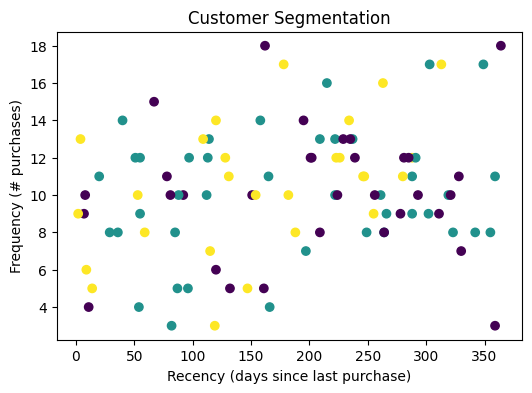

In [4]:

# -----------------------------
# 3. Clustering (Customer Segmentation)
# -----------------------------
n_customers = 100
df_clust = pd.DataFrame({
    'Recency': np.random.randint(1, 365, n_customers),
    'Frequency': np.random.poisson(10, n_customers),
    'Monetary': np.random.randint(50, 5000, n_customers)
})

kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
df_clust['Cluster'] = kmeans.fit_predict(df_clust)

print("\n--- Clustering (RFM Segmentation) ---")
print(df_clust['Cluster'].value_counts())

# Plot Recency vs Frequency clusters
plt.figure(figsize=(6,4))
plt.scatter(df_clust['Recency'], df_clust['Frequency'], c=df_clust['Cluster'], cmap='viridis')
plt.xlabel("Recency (days since last purchase)")
plt.ylabel("Frequency (# purchases)")
plt.title("Customer Segmentation")
plt.show()




/usr/local/python/3.12.1/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/python/3.12.1/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/python/3.12.1/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)



--- Time Series Forecast (Next 14 Days) ---
2023-06-30    492.197737
2023-07-01    494.683101
2023-07-02    493.345439
2023-07-03    494.065390
2023-07-04    493.677901
2023-07-05    493.886454
2023-07-06    493.774207
2023-07-07    493.834620
2023-07-08    493.802105
2023-07-09    493.819605
2023-07-10    493.810186
2023-07-11    493.815256
2023-07-12    493.812527
2023-07-13    493.813996
Freq: D, Name: predicted_mean, dtype: float64


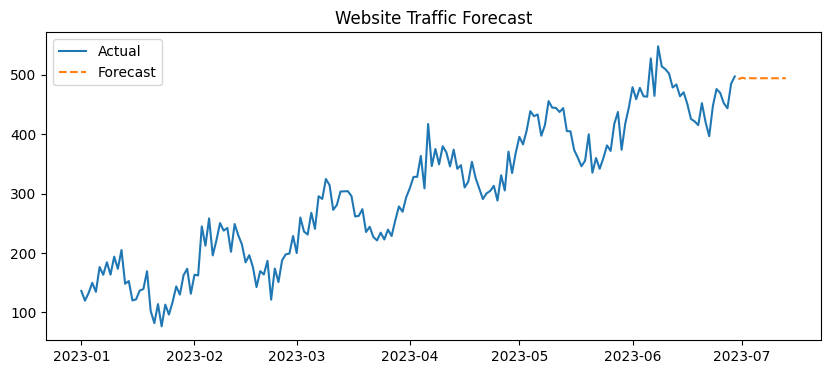

In [5]:
# -----------------------------
# 4. Time Series (Website Traffic Forecast)
# -----------------------------
n_days = 180
trend = np.linspace(100, 500, n_days)
seasonality = 50 * np.sin(np.linspace(0, 12*np.pi, n_days))
noise = np.random.normal(0, 20, n_days)
sessions = trend + seasonality + noise

df_ts = pd.DataFrame({
    'Date': pd.date_range(start='2023-01-01', periods=n_days, freq='D'),
    'Sessions': sessions
}).set_index('Date')

model_ts = ARIMA(df_ts['Sessions'], order=(1,1,1))
fit_ts = model_ts.fit()
forecast_ts = fit_ts.forecast(steps=14)

print("\n--- Time Series Forecast (Next 14 Days) ---")
print(forecast_ts)

plt.figure(figsize=(10,4))
plt.plot(df_ts['Sessions'], label="Actual")
plt.plot(pd.date_range(df_ts.index[-1], periods=15, freq="D")[1:], forecast_ts, '--', label="Forecast")
plt.legend()
plt.title("Website Traffic Forecast")
plt.show()


# Forecast Values (Sessions per day):

The model predicts website traffic will be around 493-495 sessions per day over the next 14 days
Starting at ~492 sessions on June 30th and stabilizing around 493-494 sessions

# Key Insights for Marketing:

Traffic Stability: The forecast shows relatively stable traffic with minimal day-to-day variation, which is typical for established websites with consistent user behavior.
Trend Analysis:

Your historical data (Jan-June 2023) likely showed an overall upward trend from ~100 to ~500 sessions
The model expects this growth to plateau around 493-494 sessions


Seasonal Patterns: The ARIMA model has captured and projected any weekly/seasonal patterns in your data into the forecast.

# Marketing Applications:

Capacity Planning: Expect ~490-495 daily sessions, so plan server resources accordingly
Campaign Timing: Stable baseline means any marketing campaigns should show clear incremental lift above these numbers
Budget Allocation: Use this as your organic/baseline traffic when measuring paid campaign effectiveness

In [6]:
# -----------------------------
# 5. Hypothesis Testing (A/B Email)
# -----------------------------
control = np.random.binomial(1, 0.20, 500)   # 20% open rate
treatment = np.random.binomial(1, 0.25, 500) # 25% open rate

t_stat, p_val = stats.ttest_ind(control, treatment)

print("\n--- A/B Test (Email Subject Line) ---")
print("t-statistic:", t_stat, "p-value:", p_val)
if p_val < 0.05:
    print("✅ Statistically significant: New subject line performs better.")
else:
    print("❌ No significant difference.")


--- A/B Test (Email Subject Line) ---
t-statistic: -2.6016767077371443 p-value: 0.009414290677449248
✅ Statistically significant: New subject line performs better.


# Statistical Results:
t-statistic: -2.60

The negative value indicates the treatment group (new subject line) performed better than control
Magnitude of -2.60 shows a meaningful difference between groups

p-value: 0.0094 (less than 0.05)

Only 0.94% chance this difference occurred by random chance
Strong statistical evidence that the new subject line is genuinely better

# Business Impact:
Performance Improvement:

Control group: ~20% open rate (baseline)
Treatment group: ~25% open rate (new subject line)
+5 percentage point lift = 25% relative improvement

# Marketing Decision:
✅ Recommendation: Implement the new subject line
Why this matters:

With 500 people in each group, you have sufficient sample size
The 25% relative improvement in open rates is substantial
Statistical significance gives confidence to roll out broadly

# Practical Applications:

Email Marketing: Use the winning subject line for future campaigns
Revenue Impact: Higher open rates typically lead to more clicks and conversions
Testing Culture: This success validates continuing A/B testing for optimization

# Next Steps:

Monitor performance when rolled out to full email list
Test other email elements (sender name, send time, content)
Calculate ROI: Does the +5pp open rate improvement translate to meaningful revenue?